In [2]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import time
import math

# 1 数据读取
 - 每秒所有采集数据放置在一行，数据间用空格分隔，不同类型数据（例如空间变位的三个方向、风速和风向）之间用逗号分隔

#### 1.1 读入数据

In [3]:
# 读取数据，返回dataframe格式
def readFile(path):
    return pd.read_csv(path)
path = r"..\数据\浦仪夹江大桥数据5.4\主跨跨中箱内温湿度TH-G-03.csv"
df = readFile(path)
del df['测点编号']

In [4]:
df.head()

,采集时间,温度,湿度
0,2021-05-04 00:00:00,27.39,39.95
1,2021-05-04 00:00:01,27.39,39.99
2,2021-05-04 00:00:02,27.41,39.99
3,2021-05-04 00:00:03,27.39,40.00
4,2021-05-04 00:00:04,27.39,40.02


In [5]:
df.tail()

,采集时间,温度,湿度
170117,2021-05-05 23:58:43,26.97,40.88
170118,2021-05-05 23:58:44,26.97,40.88
170119,2021-05-05 23:58:45,26.97,40.88
170120,2021-05-05 23:58:46,27.02,40.84
170121,2021-05-05 23:58:47,27.00,NaN


In [15]:
# 删掉最后一行
df = df[:-1]

#### 1.2  数据校验

In [6]:
# 数据类型转换
def change_datatype(df):
    #df["温度"] = df["温度"].apply(lambda x: np.array(x.split(" "), dtype = float))
    #df["湿度"] = df["湿度"].apply(lambda x: np.array(x.split(" "), dtype = float))
    df["采集时间"] = df["采集时间"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    return df
df = change_datatype(df)
df.head()

,采集时间,温度,湿度
0,2021-05-04 00:00:00,27.39,39.95
1,2021-05-04 00:00:01,27.39,39.99
2,2021-05-04 00:00:02,27.41,39.99
3,2021-05-04 00:00:03,27.39,40.00
4,2021-05-04 00:00:04,27.39,40.02


# 2 数据预处理
 - 针对数据校验的结果，对数据进行进一步处理

In [7]:
df.to_csv('..\数据\浦仪夹江大桥数据5.4\disposed\跨中温湿度.csv')

#### 2.2 归一化

In [8]:
disposed_df = pd.read_csv('..\数据\浦仪夹江大桥数据5.4\disposed\跨中温湿度.csv',index_col=False)
del disposed_df['Unnamed: 0']
disposed_df['class'] = np.array([i[:15] for i in disposed_df['采集时间'].values])
disposed_df['采集时间'] = disposed_df["采集时间"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) 

# def normalization(df,columns=[]):
#     for col in columns:
#         df[columns] = df[columns] / (df[columns].max() - df[columns].min())
#         df[columns] = df[columns] - df[columns].mean()
#     return df

# cols = ['主梁挠度']
# disposed_df = normalization(disposed_df,cols)

In [9]:
disposed_df

,采集时间,温度,湿度,class
0,2021-05-04 00:00:00,27.39,39.95,2021-05-04 00:0
1,2021-05-04 00:00:01,27.39,39.99,2021-05-04 00:0
2,2021-05-04 00:00:02,27.41,39.99,2021-05-04 00:0
3,2021-05-04 00:00:03,27.39,40.00,2021-05-04 00:0
4,2021-05-04 00:00:04,27.39,40.02,2021-05-04 00:0
...,...,...,...,...
170117,2021-05-05 23:58:43,26.97,40.88,2021-05-05 23:5
170118,2021-05-05 23:58:44,26.97,40.88,2021-05-05 23:5
170119,2021-05-05 23:58:45,26.97,40.88,2021-05-05 23:5
170120,2021-05-05 23:58:46,27.02,40.84,2021-05-05 23:5


#### 2.3 原始数据可视化

Text(0.5, 1.0, '竖向位移')

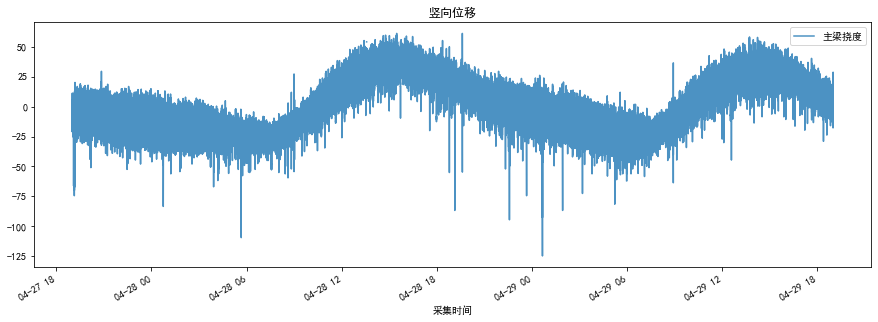

In [16]:
#disposed_df['采集时间'] = disposed_df["采集时间"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f')) 
disposed_df.index = disposed_df['采集时间']

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

disposed_df[['主梁挠度']].plot(figsize=(15,5),alpha=0.8)
plt.title('竖向位移')

# 2 数据分析

#### 2.1 以十分钟为单位划分数据集
 - 计算窗体时间内的平均Vx、Vy、Vz和平均风速的风向
 - 计算紊流度：
     - Iu = sigma_vx/sqrt(vx^2+vy^2)
     - Iv = sigma_vy/sqrt(vx^2+vy^2)
     - Iw = sigma_vz/sqrt(vx^2+vy^2)

In [10]:
def get_stats(df):
    result = df.groupby('class').agg({'采集时间':min, '温度':np.mean, '湿度':np.mean}) 
    result.columns = ['采集时间','温度平均值','湿度平均值']
    return result

In [11]:
stats = get_stats(disposed_df)
stats.reset_index(inplace=True)
del stats['class']

In [12]:
stats

,采集时间,温度平均值,湿度平均值
0,2021-05-04 00:00:00,27.321650,40.413083
1,2021-05-04 00:10:00,27.083933,41.331600
2,2021-05-04 00:20:00,26.878850,41.929267
3,2021-05-04 00:30:00,26.697140,42.301973
4,2021-05-04 00:40:00,26.522643,42.512896
...,...,...,...
283,2021-05-05 23:10:00,27.650883,39.114917
284,2021-05-05 23:20:00,27.486900,39.413250
285,2021-05-05 23:30:00,27.335117,39.771083
286,2021-05-05 23:40:00,27.176304,40.274013


In [13]:
stats.to_csv('..\数据\浦仪夹江大桥数据5.4\processed_data\跨中温湿度.csv')